# PCDP 2014 Data Profile

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10000

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import sqlite3
import pcdp

In [2]:
visit = pcdp.load_data('visit')

In [3]:
visit.head()

,Year,Visit,Patient,Gender,Race,Ethnicity,TriageCat,PayerType,EDDisposition,ModeOfArrival,AgeInYears,AgeInMonths,AgeInDays,TriageDayofWeek,TriageHour,TriageToDischargeMinutes
0,2014,787284,2,Male,Other,Hispanic,Non-acute,Medicaid (including SCHIP),Discharged,Non-EMS/Walk-in,5,69,2128,Monday,11.0,188.0
1,2014,235413,8,Female,White,Non-Hispanic,Emergent,Medicaid (including SCHIP),Admitted,Non-EMS/Walk-in,14,176,5378,Saturday,22.0,198.0
2,2014,453897,10,Female,Black or African American,Non-Hispanic,Urgent,Medicaid (including SCHIP),Admitted,Non-EMS/Walk-in,6,72,2210,Monday,19.0,385.0
3,2014,781662,10,Female,Black or African American,Non-Hispanic,Emergent,Medicaid (including SCHIP),Admitted,Non-EMS/Walk-in,6,76,2335,Sunday,17.0,332.0
4,2014,175773,37,Male,White,Hispanic,Not-urgent,Medicaid (including SCHIP),Discharged,Non-EMS/Walk-in,6,75,2311,Tuesday,18.0,143.0


In [4]:
def table(column, data=None):
    t = data.groupby(column)[[column]].count()
    t.index = t.index.astype('object')
    
    t['n'] = t[column].dropna()
    t['%'] = np.round(t['n']/t['n'].sum()*1000)/10
    
    return t[['n', '%']]

We need to verify that the files have been read correctly

In [5]:
categoricals = ['Year',
                'Gender', 'Race', 'Ethnicity',
                'TriageCat', 'PayerType', 'EDDisposition', 'ModeOfArrival',
                'AgeInYears',
                'TriageDayofWeek', 'TriageHour']

visit_frequencies = pd.concat([table(c, data=visit) for c in categoricals], keys=categoricals)
visit_frequencies

n  \
Year            2014                                                1184378   
Gender          Female                                               558655   
                Male                                                 625676   
                Stated Unknown                                           47   
Race            American Indian or Alaskan Native                      1899   
                Asian                                                 20944   
                Black or African American                            442214   
                Native Hawaiian or Other Pacific Islander              3077   
                White                                                484619   
                Multiple Races                                        32685   
                Stated Unknown                                        45976   
                Other                                                145871   
Ethnicity       Hispanic                                             258180   
                Non-Hispanic                                         889486   
                Stated Unknown                                        26771   
TriageCat       Critical                                               8149   
                Emergent                                             176498   
                Urgent                                               407572   
                Not-urgent                                           437205   
                Non-acute                                            123697   
                Unknown                                                5725   
PayerType       Commercial Insurance                                 368599   
                Medicaid (including SCHIP)                           745627   
                Medicare                                               2651   
                Other                                                  2050   
                Other Governmental Insurance (including CHAMPUS...    11717   
                Self Pay                                              44065   
                Stated Unknown                                            0   
                Workers Compensation                                     33   
EDDisposition   23 Hour Observation Unit/RTU                          15184   
                Admitted                                             160550   
                Left Against Medical Advice                            1777   
                Died                                                    341   
                Discharged                                           967376   
                Left Without Treatment                                17270   
                Other                                                  3149   
                Stated Unknown                                            1   
                Transferred                                            7014   
ModeOfArrival   EMS Air                                                2224   
                EMS Ground                                           100600   
                Non-EMS/Walk-in                                     1003371   
                Other                                                 12611   
                Stated Unknown                                         5816   
AgeInYears      0                                                    188045   
                1                                                    152135   
                2                                                    106081   
                3                                                     83844   
                4                                                     70469   
                5                                                     65780   
                6                                                     58347   
                7                            

In [6]:
continuous = ['AgeInMonths', 'AgeInDays', 'TriageToDischargeMinutes']
pd.concat([visit[s].dropna().describe() for s in continuous], keys=continuous).unstack()

,count,mean,std,min,25%,50%,75%,max
AgeInMonths,1184378.0,77.093659,65.392156,0.0,20.0,58.0,127.0,227.0
AgeInDays,1184378.0,2361.111756,1990.429379,0.0,609.0,1780.0,3889.0,6939.0
TriageToDischargeMinutes,1178594.0,387.894704,193735.909057,-60093007.0,101.0,163.0,254.0,45667256.0


Numerical summaries like these will only get you so far. We should create bar charts and histograms to see what's going on.

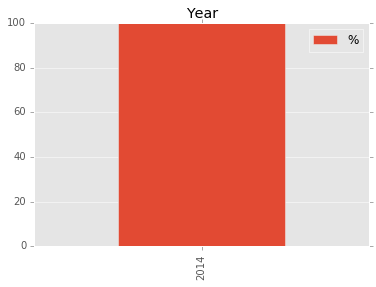

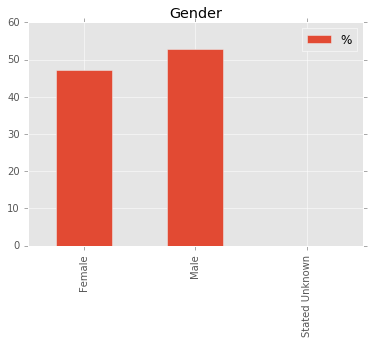

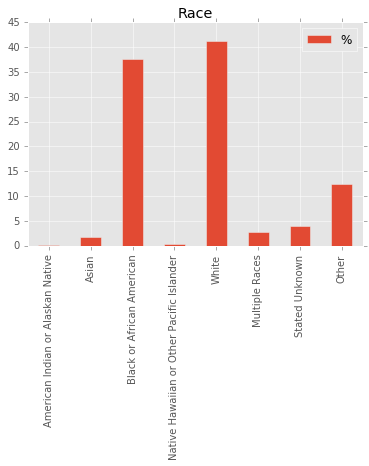

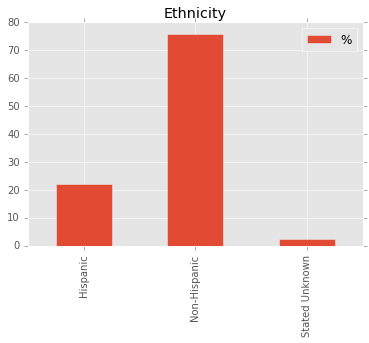

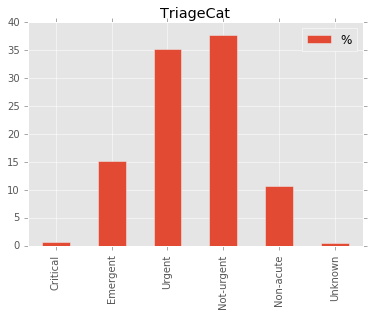

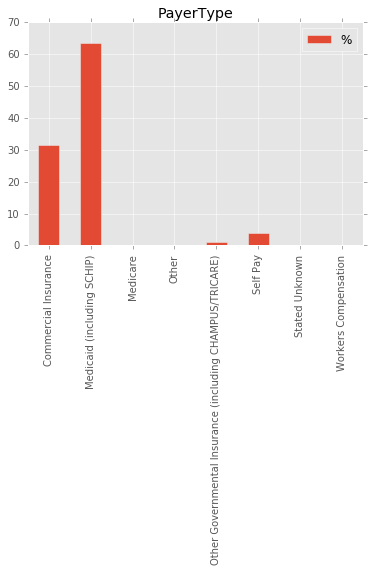

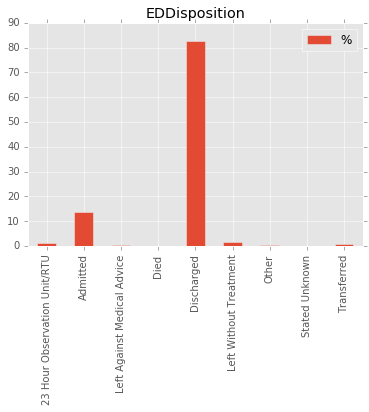

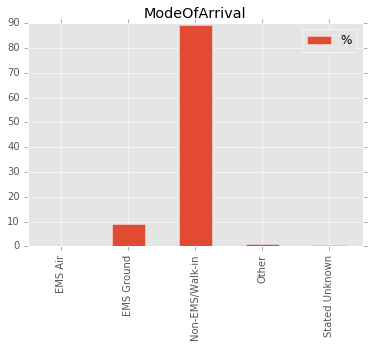

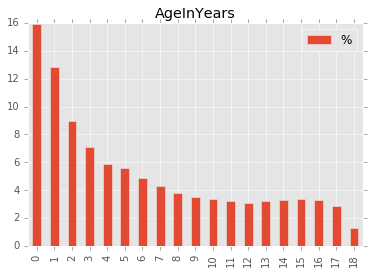

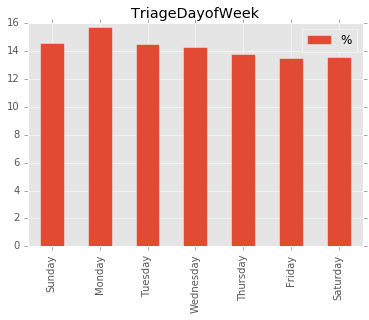

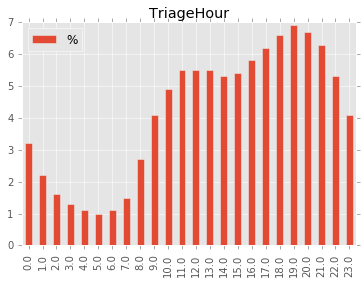

In [7]:
for grp, df in visit_frequencies.groupby(level=0):
    df.set_index(df.index.droplevel(), inplace=True)
    df[['%']].plot(kind='bar', title=grp)

Mostly these look good, but they aren't the most convenient variables in the world. We should make the following changes

TODO

  - Gender, Race, Ethnicity, TriageCat, PayerType, EDDisposition, ModeOfArrival have 'Unknown'
  -  Race and ethnicity should be combined (White NH, Black NH, Other NH, Hispanic)
  - PayerType should be simplified (commercial vs. government vs self-pay/other)
  - EDisposition should be simplified (Hospitalized or worse vs. discharged or left)
  - ModeOfArrival should be simplified (EMS vs. Non-EMS)

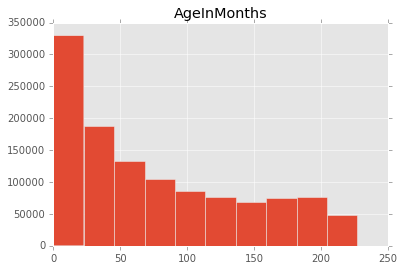

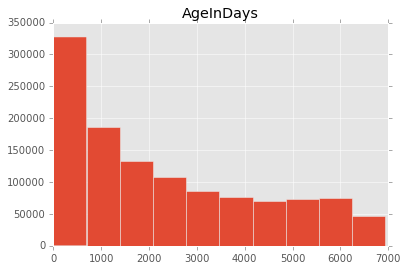

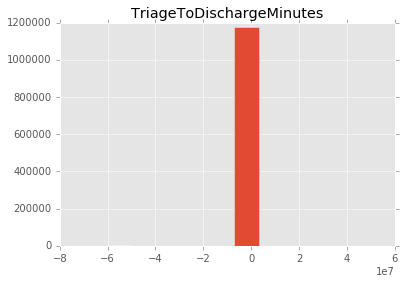

In [8]:
for c in continuous:
    visit[[c]].hist()

Clearly something is horribly wrong with TriageToDischargeMinutes. We should get rid of the negative values and truncate the times to fall within a 24 hour window (don't really care if the visit is longer).